In [1]:
# import warnings
# warnings.filterwarnings('ignore') 

import os
import sys
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("bmh")
%matplotlib inline
import missingno as msno
import itertools
from IPython.display import display
from scipy.optimize import leastsq

from speclib.userActivityFunctions import getComdataMean, df2punchcard
from speclib.loaders import loadUserPhonenumberDict, getUserList, Useralias, loadUserParallel, dict2DataFrame, users2DataFrame
from speclib.plotting import looseAxesLimits, barSBS, countsOnBarPlot, plotPunchcard

Prepare to load users

In [2]:
userLst = getUserList() 
useralias = Useralias() 
userSpec = [(username, useralias[username], ('call', 'sms')) for username in userLst]
for el in userSpec[:10]:
    print(el)

('28b76d7b7879d364321f164df5169f', 'u0001', ('call', 'sms'))
('f41c375b5c87d3593b963b49a3f9a3', 'u0002', ('call', 'sms'))
('b600d2468831e0b3480a69af903dfc', 'u0003', ('call', 'sms'))
('dbbf1adb3264464838b938429d674b', 'u0004', ('call', 'sms'))
('3b6887b57d97d1ff1e1a674abfa5e3', 'u0005', ('call', 'sms'))
('972204b2d674a4681b2cb77e70c2b8', 'u0006', ('call', 'sms'))
('a94b118a62ebe7883a42d8966003b5', 'u0007', ('call', 'sms'))
('a71a2187b259601a2a98005fa20012', 'u0008', ('call', 'sms'))
('af1a0a02a3be070703128acde8d4b0', 'u0009', ('call', 'sms'))
('07be9cae12e7949a3ea091a234d30f', 'u0010', ('call', 'sms'))


In [3]:
users = loadUserParallel(userSpec, n=15) 

Turn loaded user data into a DateFrame

In [5]:
df = users2DataFrame(users, useralias, n=15) 
del users

In [6]:
display(df.head(), df.tail()) 

body  duration  hour                                    number  \
user  comtype                                                                  
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   

                  timeint           timestamp  weekday  
user  comtype                                           
u0001 call     1386255771 2013-12-05 15:02:51        3  
      call     1386330792 2013-12-06 11:53:12        4  
      call     1386330838 2013-12-06 11:53:58        4  
      call     1386509631 2013-12-08 13:33:51        6  
      call     1386526906 2013-12-08 18:21:46        6

body  duration  hour  \
user  comtype                                                             
u1060 sms      85c37224ae3ac1aaac42ca041ef07f7d52fdd26f       NaN    19   
      sms      76635263c51db6fba9ca5d6f1375a4d858d8f4ce       NaN     1   
      sms      7ce9013d9a4c9b709401e071fbfc27021b84bd5c       NaN     1   
      sms      6ab6169af1096c4a45b806ba2136be142e429e8a       NaN     2   
      sms      af324529533e2c48ef24e09c7a9c95ca1b6977be       NaN     0   

                                                 number     timeint  \
user  comtype                                                         
u1060 sms      819a809cde7a920260649fcbe181b9907d9e5f16  1418931227   
      sms      819a809cde7a920260649fcbe181b9907d9e5f16  1418951184   
      sms      819a809cde7a920260649fcbe181b9907d9e5f16  1418953080   
      sms      819a809cde7a920260649fcbe181b9907d9e5f16  1418954688   
      sms      7fb4e80dd7c2883ca6141f7630ccbde33636ac90  1420331146   

                        timestamp  weekday  
user  comtype                               
u1060 sms     2014-12-18 19:33:47        3  
      sms     2014-12-19 01:06:24        4  
      sms     2014-12-19 01:38:00        4  
      sms     2014-12-19 02:04:48        4  
      sms     2015-01-04 00:25:46        6

Apparently there is messages with no recieving number…

In [7]:
idx = df.loc["u0645", "sms"].body == "cc0bf55fbc000c9ffa5ca348a1724744ae704ae0"

df.loc["u0645", "sms"][idx] 

,,body,duration,hour,number,timeint,timestamp,weekday
user,comtype,,,,,,,
u0645,sms,cc0bf55fbc000c9ffa5ca348a1724744ae704ae0,NaN,9,,1417166621,2014-11-28 09:23:41,4


# Some plotting 

Plot activity for all users calls and sms' side by side. Each category sums up to 1.

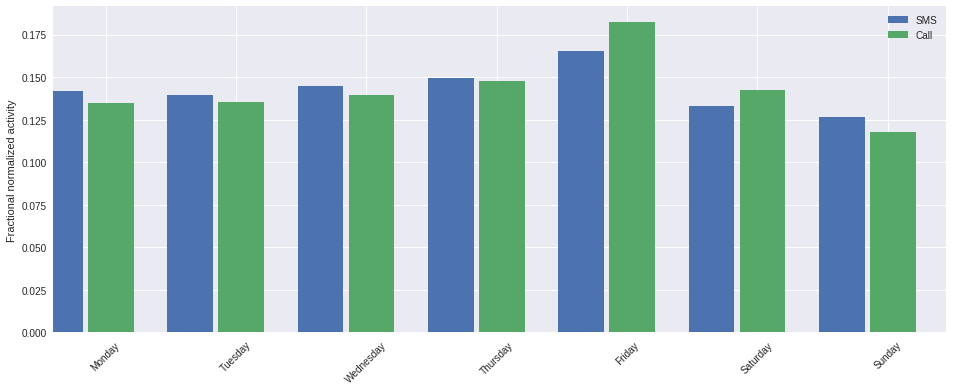

In [8]:
callWeek = df.xs('call', level=1).weekday.value_counts()
callWeek /= callWeek.sum()
smsWeek = df.xs('sms', level=1).weekday.value_counts()
smsWeek /= smsWeek.sum() 
fig, ax = plt.subplots(figsize=(16, 6)) 
d0 = {'y': smsWeek.sort_index(), 'label': 'SMS'} 
d1 = {'y': callWeek.sort_index(), 'label': 'Call'} 
barSBS(ax, d0, d1) 
ax.set_ylabel("Fractional normalized activity") 
ax.set_xticks(np.arange(0, 7) + 0.35) 
ax.set_xticklabels( ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"), rotation=45 );
ax.set_xlim((-0.05, 6.8));

Index into a sublevel of the MultiIndex like so:

In [9]:
sms = df.xs('sms', level=1)
display(sms.head(), sms.tail()) 

,body,duration,hour,number,timeint,timestamp,weekday
user,,,,,,,
u0001,1f009968edbedce71a3dc7938ca5994fe1eddfd7,NaN,11,d3eff7c2f16a30f8d386687baae68065fe019b6a,1386242729,2013-12-05 11:25:29,3
u0001,c555e1011c6b384d47dfb3610100456a969b9ac8,NaN,15,36a4861f3f67cbf88b578d77743d1f5a8ddf604f,1386256187,2013-12-05 15:09:47,3
u0001,e9330fb3c79bc8bf9191b9864099996ba9510ef0,NaN,15,d3eff7c2f16a30f8d386687baae68065fe019b6a,1386259154,2013-12-05 15:59:14,3
u0001,6ef9e682aab3c5f3964428189e5fe8f09ec48199,NaN,16,a5adeaffb8050bbc36ac4242fd9beed0ff846439,1386259270,2013-12-05 16:01:10,3
u0001,8a7dcaab6b6d9799d4a5f07bade5c67f90350712,NaN,16,a5adeaffb8050bbc36ac4242fd9beed0ff846439,1386259808,2013-12-05 16:10:08,3


,body,duration,hour,number,timeint,timestamp,weekday
user,,,,,,,
u1060,85c37224ae3ac1aaac42ca041ef07f7d52fdd26f,NaN,19,819a809cde7a920260649fcbe181b9907d9e5f16,1418931227,2014-12-18 19:33:47,3
u1060,76635263c51db6fba9ca5d6f1375a4d858d8f4ce,NaN,1,819a809cde7a920260649fcbe181b9907d9e5f16,1418951184,2014-12-19 01:06:24,4
u1060,7ce9013d9a4c9b709401e071fbfc27021b84bd5c,NaN,1,819a809cde7a920260649fcbe181b9907d9e5f16,1418953080,2014-12-19 01:38:00,4
u1060,6ab6169af1096c4a45b806ba2136be142e429e8a,NaN,2,819a809cde7a920260649fcbe181b9907d9e5f16,1418954688,2014-12-19 02:04:48,4
u1060,af324529533e2c48ef24e09c7a9c95ca1b6977be,NaN,0,7fb4e80dd7c2883ca6141f7630ccbde33636ac90,1420331146,2015-01-04 00:25:46,6


In [10]:
call = df.xs('call', level=1).hour.value_counts()
call /= call.sum()
sms = df.xs('sms', level=1).hour.value_counts()
sms /= sms.sum() 

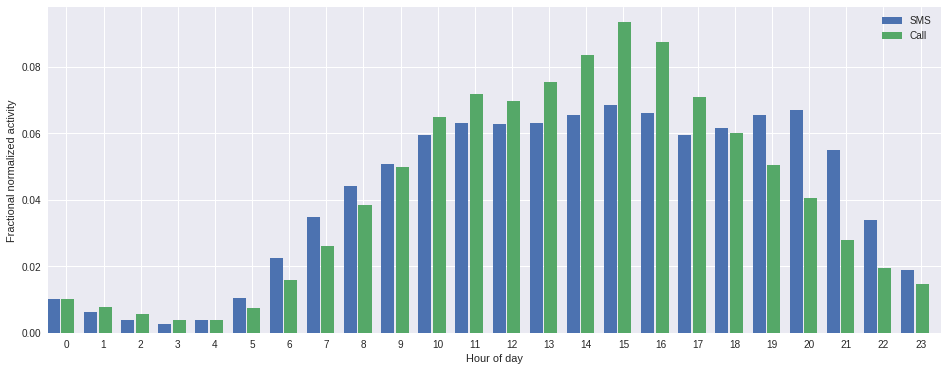

In [11]:
fig, ax = plt.subplots(figsize=(16, 6)) 
d0 = {'y': sms.sort_index(), 'label': 'SMS'} 
d1 = {'y': call.sort_index(), 'label': 'Call'} 
barSBS(ax, d0, d1) 
ax.set_ylabel("Fractional normalized activity") 
ax.set_xlabel("Hour of day") 
ax.set_xticks(np.arange(0, 24, dtype=np.int) + 0.35)
ax.set_xticklabels(["%d"%i for i in range(24)])
ax.set_xlim((-0.15, 23.89)); 

Count the number of times each uses calls or writes each unique phone number

In [12]:
if 'comFreq.pandasPickle' in os.listdir('.'):
    comFreq = pd.read_pickle('comFreq.pandasPickle')  # Computation is slow
else:
    comFreq = pd.DataFrame(index=df.index.get_level_values('user').unique(), columns=('sms', 'call'))
    comFreq.columns.name = 'comtype'
    for user in df.index.get_level_values('user').unique():
        for comtype in df.loc[user].index.unique():
            comFreq.loc[user, comtype] = df.loc[user, comtype].number.value_counts().values
    counterLambda = lambda x: 0 if np.any(pd.isnull(x)) else x.size
    comFreq['smsUnique'] = comFreq.sms.apply(counterLambda)
    comFreq['callUnique'] = comFreq.call.apply(counterLambda) 

In [13]:
comFreq.head() 

comtype,sms,call,smsUnique,callUnique
user,,,,
u0001,"[608, 417, 355, 355, 268, 228, 134, 124, 117, ...","[210, 158, 155, 123, 95, 78, 76, 41, 21, 19, 1...",57,90
u0002,"[458, 321, 293, 148, 101, 96, 73, 70, 63, 62, ...","[33, 27, 21, 17, 14, 14, 13, 13, 12, 12, 9, 8,...",151,156
u0003,"[285, 228, 165, 85, 67, 52, 51, 46, 44, 42, 32...","[490, 198, 80, 61, 60, 35, 27, 23, 22, 15, 14,...",60,89
u0004,"[7898, 486, 400, 373, 363, 349, 303, 280, 275,...","[187, 139, 139, 105, 61, 60, 60, 52, 49, 42, 4...",153,239
u0005,"[5245, 503, 341, 244, 241, 225, 108, 108, 89, ...","[273, 135, 114, 105, 78, 59, 54, 30, 23, 23, 2...",63,85


Plot the distribution

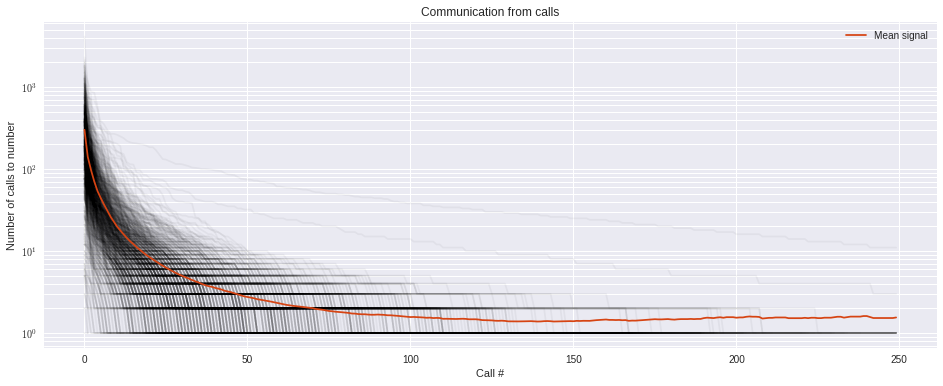

In [14]:
fig, ax = plt.subplots(figsize=(16,6)) 
nMaxEvents = 250
meanColor = '#d64413'
for user in comFreq.index:
    try:
        ax.semilogy(comFreq.loc[user].call[:nMaxEvents], 'k-', alpha=0.04)
    except TypeError:  # length-1 elements are apparently turned into floats, which isn't subscriptable
        ax.semilogy(comFreq.loc[user].call, 'k-', alpha=0.04)
ax.grid(which='minor')
ax.semilogy(getComdataMean(comFreq, 'call', 'callUnique')[:nMaxEvents], color=meanColor, label='Mean signal') 
ax.set_xlabel('Call #')
ax.set_ylabel("Number of calls to number")
ax.set_title("Communication from calls")
ax.legend() 

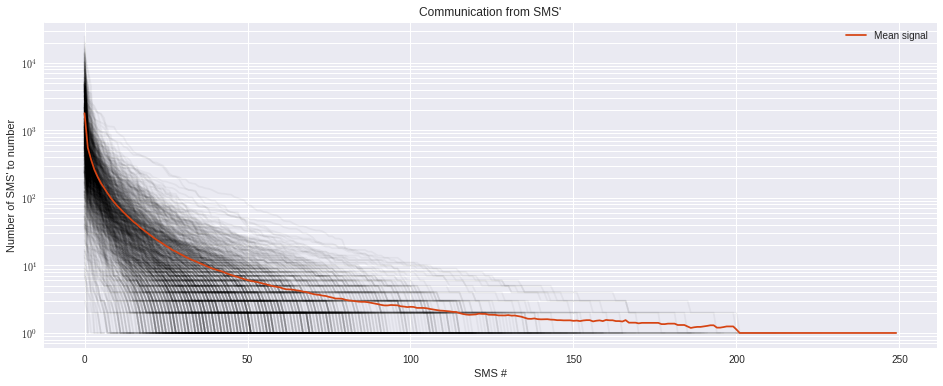

In [15]:
fig, ax = plt.subplots(figsize=(16,6)) 
nMaxEvents = 250
meanColor = '#d64413'
for user in comFreq.index:
    try:
        ax.semilogy(comFreq.loc[user].sms[:nMaxEvents], 'k-', alpha=0.04)
    except TypeError:  # length-1 elements are apparently turned into floats, which isn't subscriptable
        ax.semilogy(comFreq.loc[user].sms, 'k-', alpha=0.04)
ax.grid(which='minor')
ax.semilogy(getComdataMean(comFreq, 'sms', 'smsUnique')[:nMaxEvents], color=meanColor, label="Mean signal") 
ax.set_xlabel('SMS #')
ax.set_ylabel("Number of SMS' to number")
ax.set_title("Communication from SMS'")
ax.legend() 

Attempt a fit of the data, as I suspect it could be fittet well with a powerlaw.

While the fit did converge, I'm not convinced that it's better than my own guess… are the results weighted towards the lower end, or something like that? Or did my algorithm just converge on a local minima?

/lscr_paper/allan/miniconda3/envs/mpl2/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in power
/lscr_paper/allan/miniconda3/envs/mpl2/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt
/lscr_paper/allan/miniconda3/envs/mpl2/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in power
/lscr_paper/allan/miniconda3/envs/mpl2/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in power


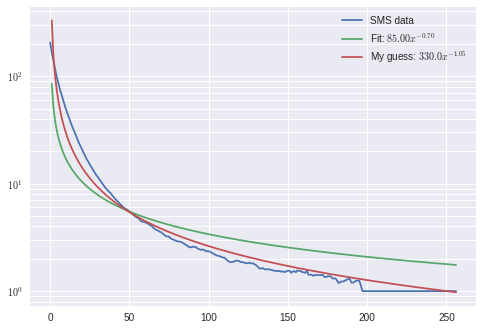

In [16]:
cut = 4
smsMean = getComdataMean(comFreq, 'sms', 'smsUnique')
smsMean = smsMean[cut:]
x = np.arange(len(smsMean), dtype=np.double) 
errfunc = lambda p, x, y: np.sqrt(y**2 - (p[0]*x**p[1])**2)
fit, _ = leastsq(errfunc, (85, -0.7), args=(x, smsMean))
fig, ax = plt.subplots()
ax.semilogy(x, smsMean, label='SMS data')
ax.semilogy(x, fit[0]*x**fit[1], label=r'Fit: $%.2f x^{%.2f}$' % tuple(fit)) 
ax.semilogy(x, 330*x**-1.05, label=r"My guess: $330.0 x^{-1.05}$")
ax.legend()
ax.grid(which='minor') 

# Clean the data

Check the min and max dates… seems some users didn't set the time on their phones
 $a^2$

In [17]:
df.head() 

body  duration  hour                                    number  \
user  comtype                                                                  
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   

                  timeint           timestamp  weekday  
user  comtype                                           
u0001 call     1386255771 2013-12-05 15:02:51        3  
      call     1386330792 2013-12-06 11:53:12        4  
      call     1386330838 2013-12-06 11:53:58        4  
      call     1386509631 2013-12-08 13:33:51        6  
      call     1386526906 2013-12-08 18:21:46        6

In [18]:
df.head() 

body  duration  hour                                    number  \
user  comtype                                                                  
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   

                  timeint           timestamp  weekday  
user  comtype                                           
u0001 call     1386255771 2013-12-05 15:02:51        3  
      call     1386330792 2013-12-06 11:53:12        4  
      call     1386330838 2013-12-06 11:53:58        4  
      call     1386509631 2013-12-08 13:33:51        6  
      call     1386526906 2013-12-08 18:21:46        6

In [19]:
display(df.timestamp.min(), df.timestamp.max() ) 

Timestamp('1970-01-02 00:02:11')

Timestamp('2021-09-20 15:49:59')

Print aliases for all usesr which have events before 2013 and after 2015, along with min and max dates

In [20]:
for user in df.index.get_level_values('user').unique():
    if df.loc[user].timestamp.min().year < 2013 or df.loc[user].timestamp.max().year > 2015:
        print(user, df.loc[user].timestamp.min(), df.loc[user].timestamp.max(), sep="\t"*2)

u0003		2012-10-05 15:57:52		2015-03-23 13:10:44
u0051		2011-06-21 17:10:33		2015-01-09 18:54:17
u0148		2013-09-13 05:19:57		2021-09-20 15:49:59
u0194		2011-12-26 15:57:14		2014-10-11 13:13:09
u0391		1970-01-02 00:02:11		2014-11-23 15:11:49
u0461		2011-12-01 14:00:46		2014-10-29 10:32:52
u0466		2012-10-09 13:37:53		2014-08-27 13:49:09
u0488		2011-05-30 14:27:37		2014-09-09 20:49:40
u0808		1970-01-02 01:23:04		2014-10-08 20:18:54
u0825		2012-10-02 12:38:05		2015-03-18 18:27:08
u0831		2012-10-02 12:18:39		2014-10-09 23:08:58
u0834		1980-01-06 04:25:47		2015-03-21 16:46:15
u0872		1970-01-02 00:04:11		2014-11-20 14:53:51
u0898		2012-01-01 03:05:37		2015-02-02 17:32:06
u1010		2011-11-23 10:11:22		2015-03-08 02:00:11
u1048		2011-10-01 16:48:15		2015-03-19 16:39:17


Add a "year" column to the DataFrame, and plot a bar chart over the years

In [21]:
df['year'] = df.timestamp.apply(lambda x: x.year)

Seems like there was some activity as early as in 2011. 1970 is proably relating to a reset phone counting for Unix time 0, and will be removed along with events which "occured" in 1980 and 2021.

1970          6
1980          1
2011       6107
2012      29931
2013    1230146
2014    3326792
2015     329758
2021         13
Name: year, dtype: int64

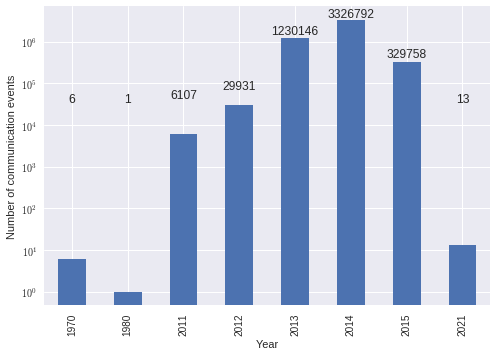

In [22]:
ax = df.year.value_counts().sort_index().plot.bar()  
ax.set_yscale('log')
# ax.grid(which='minor')
countsOnBarPlot(ax)
ax.set_ylabel("Number of communication events")
ax.set_xlabel("Year")
display(df.year.value_counts().sort_index())

Remove the faulty rows, and ensure that the number of removed rows correspond to the number of rows matched in the mask

In [23]:
rowsBefore = df.shape[0] 
mask = (df.year < 2011) | (df.year > 2016)
df = df[~mask]
rowsBefore - df.shape[0] == mask.sum() 

True

# Timebin users activity

Make a smaller dataset to experiment on... runtime tends to get large with full dataset

In [24]:
ul = ["u000%d" % i for i in range(1, 10)] 
ul 

['u0001',
 'u0002',
 'u0003',
 'u0004',
 'u0005',
 'u0006',
 'u0007',
 'u0008',
 'u0009']

In [25]:
dfs = df.loc[ul]  
dfs.index.get_level_values('user').unique() 

Index(['u0001', 'u0002', 'u0003', 'u0004', 'u0005', 'u0006', 'u0007', 'u0008',
       'u0009'],
      dtype='object', name='user')

Check smaller version of dataset vs indexed version, where calls is indexed, and u0001 is chosen for convenience

In [26]:
dfs.head() 

body  duration  hour                                    number  \
user  comtype                                                                  
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   

                  timeint           timestamp  weekday  year  
user  comtype                                                 
u0001 call     1386255771 2013-12-05 15:02:51        3  2013  
      call     1386330792 2013-12-06 11:53:12        4  2013  
      call     1386330838 2013-12-06 11:53:58        4  2013  
      call     1386509631 2013-12-08 13:33:51        6  2013  
      call     1386526906 2013-12-08 18:21:46        6  2013

In [27]:
dfs.loc[pd.IndexSlice[:, 'call'], :].loc['u0001'].head() 

,body,duration,hour,number,timeint,timestamp,weekday,year
comtype,,,,,,,,
call,NaN,29.0,15,36a4861f3f67cbf88b578d77743d1f5a8ddf604f,1386255771,2013-12-05 15:02:51,3,2013
call,NaN,0.0,11,a7a089517b6855c7144c018e74ecced67a99e6f6,1386330792,2013-12-06 11:53:12,4,2013
call,NaN,89.0,11,a7a089517b6855c7144c018e74ecced67a99e6f6,1386330838,2013-12-06 11:53:58,4,2013
call,NaN,104.0,13,36a4861f3f67cbf88b578d77743d1f5a8ddf604f,1386509631,2013-12-08 13:33:51,6,2013
call,NaN,32.0,18,36a4861f3f67cbf88b578d77743d1f5a8ddf604f,1386526906,2013-12-08 18:21:46,6,2013


In [28]:
punchcard = df2punchcard(df) 

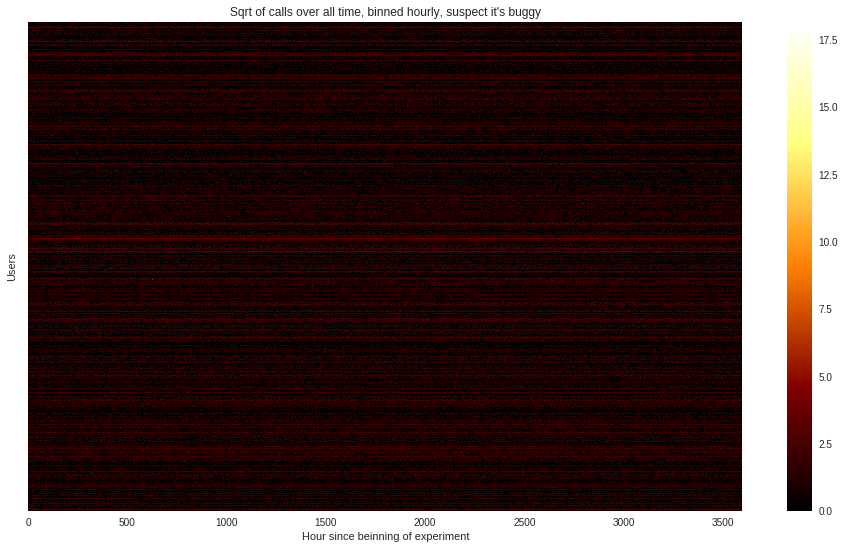

In [29]:
fig, ax = plt.subplots(figsize=(16, 9))
pc = ax.pcolor(np.sqrt(punchcard), cmap=mpl.cm.afmhot)
fig.colorbar(pc)
ax.set_xlim(0, punchcard.shape[1])
ax.set_ylim(0, punchcard.shape[0]) 
ax.set_title("Sqrt of calls over all time, binned hourly, suspect it's buggy")
ax.set_xlabel('Hour since beinning of experiment')
ax.set_ylabel('Users')
ax.set_yticklabels([]);

In [30]:
def timestamp2punchcard(timestamp):
    arr = np.zeros(24*7)
    for i, event in enumerate(timestamp):
        idx = 24*event.dayofweek + event.hour
        arr[idx] += 1
    return arr

users = df.index.get_level_values('user').unique()
nUsers = len(users)
punchcardCall = np.zeros((nUsers, 24*7))
punchcardSms = np.zeros((nUsers, 24*7))
oldPct = -1
for i, user in enumerate(users):
    newPct = round(i/len(users)*100)
    if newPct != oldPct and newPct % 10 == 0:
        print("{:.0f} %".format(newPct), end="\t")
        oldPct = newPct
    try:
        timestamp = df.loc[user, 'call'].timestamp
        punchcardCall[i, :] = timestamp2punchcard(timestamp)
    except KeyError as e:
        print("Error processing user %s (call)" % user, file=sys.stderr)
    try:
        timestamp = df.loc[user, 'sms'].timestamp
        punchcardSms[i, :] = timestamp2punchcard(timestamp)
    except KeyError as e:
        print("Error processing user %s (sms)" % user, file=sys.stderr)
    

0 %	10 %	20 %	30 %	40 %	50 %	60 %	

Error processing user u0689 (call)


70 %	

Error processing user u0760 (sms)


80 %	90 %	

Error processing user u0958 (call)


100 %	

In [31]:
punchcardCallSorted = punchcardCall[np.argsort(punchcardCall.sum(axis=1))[::-1]]

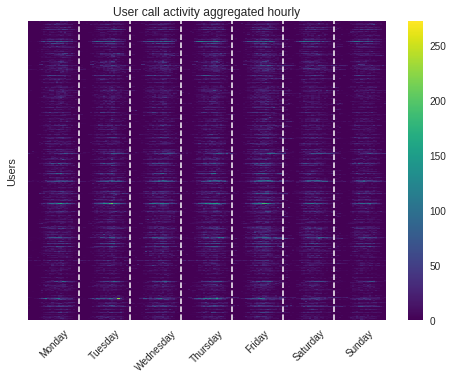

In [32]:
fig, ax = plotPunchcard(punchcardCall)
ax.set_title('User call activity aggregated hourly')

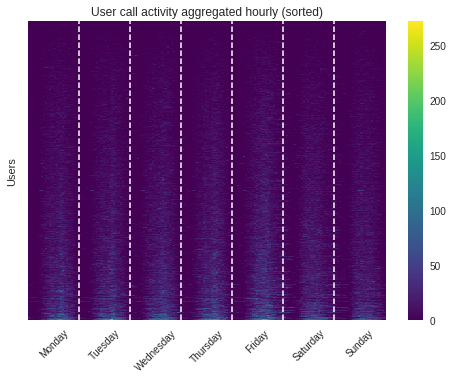

In [33]:
fig, ax = plotPunchcard(punchcardCallSorted)
ax.set_title('User call activity aggregated hourly (sorted)')

/lscr_paper/allan/miniconda3/envs/mpl2/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


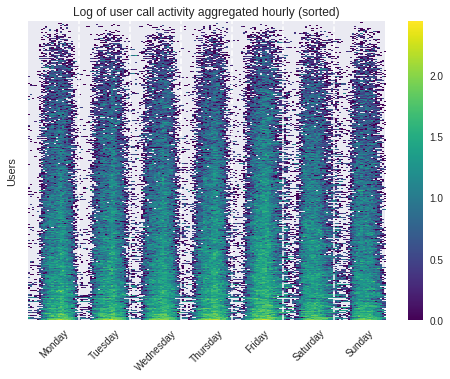

In [34]:
fig, ax = plotPunchcard(np.log10(punchcardCallSorted))
ax.set_title('Log of user call activity aggregated hourly (sorted)')

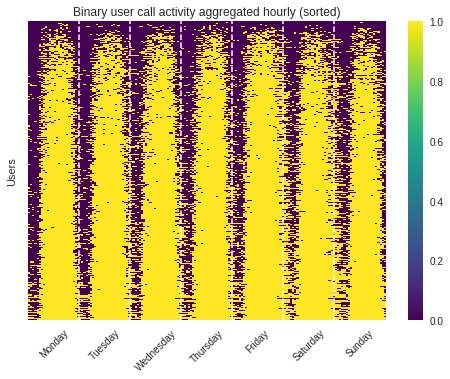

In [35]:
fig, ax = plotPunchcard(punchcardCallSorted > 0)
ax.set_title('Binary user call activity aggregated hourly (sorted)')

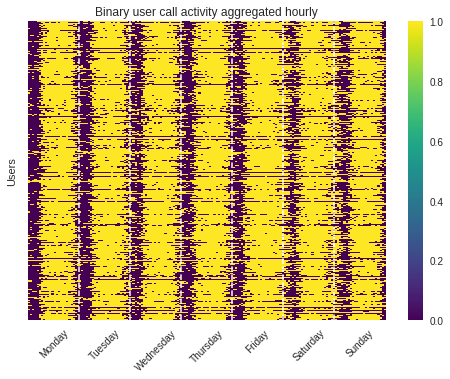

In [36]:
fig, ax = plotPunchcard(punchcardCall > 0)
ax.set_title('Binary user call activity aggregated hourly')